# Setting Up Environment

In [6]:
import gym

## Cartpole Environment

In [7]:
env = gym.make('CartPole-v0')

The rendered window env might stay unresponsive and some say this is due to jupyter notebook visualization problems.  
Looking for a way to solve this.

Using GIF looks like one solution : https://rrbb014.tistory.com/44#openai-gym%EC%9D%84-jupyter-notebook%ED%99%98%EA%B2%BD%EC%97%90%EC%84%9C-%EC%8B%A4%ED%96%89%ED%95%98%EA%B8%B0-headless-playing

In [8]:
env.reset()
# let's see 10 timesteps with random action
for _ in range(10):
    # env.render()
    observation, reward, done, info = env.step(env.action_space.sample())
    print(observation, reward, done, info)
    if done:
        break
# env.close()

[-0.04197326  0.17854117 -0.04903103 -0.3222664 ] 1.0 False {}
[-0.03840243  0.37432578 -0.05547636 -0.62999976] 1.0 False {}
[-0.03091592  0.5701762  -0.06807635 -0.9396251 ] 1.0 False {}
[-0.01951239  0.7661465  -0.08686885 -1.2528987 ] 1.0 False {}
[-0.00418947  0.572238   -0.11192682 -0.98864007] 1.0 False {}
[ 0.0072553   0.768666   -0.13169962 -1.3142762 ] 1.0 False {}
[ 0.02262862  0.9651857  -0.15798515 -1.6451108 ] 1.0 False {}
[ 0.04193233  1.1617644  -0.19088736 -1.9825613 ] 1.0 False {}
[ 0.06516762  1.3583127  -0.23053859 -2.3278093 ] 1.0 True {}


## Visualizing results

When the whole training is going on, the graph will be the mean survived timesteps for each epochs.

And the loss graph.

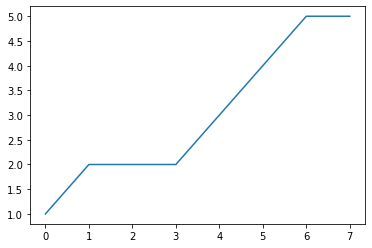

In [9]:
import matplotlib.pyplot as plt
plt.plot([1,2,2,2,3,4,5,5]);

## Model(for policy)

In [10]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.distributions.categorical import Categorical
import numpy as np

Simple Linear NN for the policy. It is from a code in CS285 lecture 3, except it uses softmax at the output layer.

In [11]:
class Net(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x      

In [12]:
net = Net()
print(net)

# example of input
print(net(torch.tensor([[1., 2., 3., 4.], [2., 3., 2., 2.]])))

Net(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
tensor([[0.6197, 0.3803],
        [0.6075, 0.3925]], grad_fn=<SoftmaxBackward0>)


# Mathematics

$$
\nabla_\theta J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \sum_{t=1}^{T} \nabla_\theta \log{\pi_\theta \left( a_{i,t} | s_{i,t} \right)}  \left( \sum_{t^\prime=t}^{T} r\left( s_{i,t}, a_{i,t} \right) \right) \\
J(\theta) = E_{\tau~p_\theta(\tau)}\left[ \sum_{t}r(s_t, a_t) \right] \approx \frac{1}{N}\sum_i\sum_{t}r(s_{i,t}, a_{i,t}) \\
\tilde{J}(\theta) \approx \frac{1}{N}\sum_{i=1}^N\sum_{t=1}^T \log{\pi_\theta \left( a_{i,t} | s_{i,t} \right)} \hat{Q}_{i,t} \\
$$

$-\tilde{J}(\theta)$ will be used as the loss function

$$
\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta) \\ = \theta - \alpha \nabla_\theta (-J(\theta))
$$

# The codes that will run to train

In [13]:
# number of samples(trajectories) for each iteration
N = 1000

# T(max length of the trajectory)
max_traj_len = 100

# The policy object
net = Net()

## run the policy to create N samples

All information about samples will be stored in a list `samples`

The final shape of the list `samples` will be

__[nth_trajectory] [state, action, reward, q_value(reward to go)]__

In [14]:
from tqdm import tqdm # to visualize the progress

# new samples for every update, because VPG is an On-policy algorithm
samples = []

for sample_i in tqdm(range(N)):
    # initial state
    observation = env.reset()
    one_traj = []
    for traj_step in range(max_traj_len):
        # rolling out the policy to get actions
        softmax_value = net(torch.from_numpy(observation)).detach()
        action = Categorical(softmax_value).sample().item()
        new_observation, reward, done, info = env.step(action)
        # append the [s, a, r] in a list
        one_traj.append([observation, action, reward])
        observation = new_observation
        if done or traj_step == (max_traj_len - 1):
            # append the trajectory in a list
            samples.append(one_traj)
            break

print('one trajectory looks like this')
for traj in samples[0]:
    print(traj)

100%|██████████| 1000/1000 [00:09<00:00, 106.18it/s]

one trajectory looks like this
[array([-0.04805719, -0.01582284, -0.03693635, -0.01078723], dtype=float32), 1, 1.0]
[array([-0.04837365,  0.17980883, -0.03715209, -0.3148914 ], dtype=float32), 0, 1.0]
[array([-0.04477747, -0.01476476, -0.04344992, -0.03415263], dtype=float32), 0, 1.0]
[array([-0.04507277, -0.20923756, -0.04413297,  0.244511  ], dtype=float32), 1, 1.0]
[array([-0.04925752, -0.01351395, -0.03924275, -0.06175944], dtype=float32), 0, 1.0]
[array([-0.0495278 , -0.20805192, -0.04047794,  0.21828844], dtype=float32), 1, 1.0]
[array([-0.05368884, -0.01237541, -0.03611217, -0.08688315], dtype=float32), 1, 1.0]
[array([-0.05393634,  0.18324506, -0.03784984, -0.39073724], dtype=float32), 0, 1.0]
[array([-0.05027144, -0.01131983, -0.04566458, -0.11022411], dtype=float32), 1, 1.0]
[array([-0.05049784,  0.18442573, -0.04786906, -0.41695708], dtype=float32), 0, 1.0]
[array([-0.04680933, -0.00998631, -0.0562082 , -0.13974121], dtype=float32), 1, 1.0]
[array([-0.04700905,  0.18589374, 

## Getting the Q-values(reward to go)

$$
\hat{Q}_{i,t} = \sum^{T}_{t^\prime=t}{r\left( s_{i, t^\prime} , a_{i, t^\prime}\right )}
$$

In [15]:
# Getting the q-values(reward to go)
q_values = []
for sample in samples:
    temp = []
    for i in range(len(sample)):
        q = 0
        for t in range(i, len(sample)):
            q += sample[t][2] # Adding the reward for time t at current trajectory
        temp.append(q)
    q_values.append(temp)

# appending the q_values to the 'samples' list
for i in range(len(q_values)):
    for j in range(len(q_values[i])):
        samples[i][j].append(q_values[i][j])
        
        
        
print('Now, one trajectory looks like this')
for traj in samples[0]:
    print(traj)

Now, one trajectory looks like this
[array([-0.04805719, -0.01582284, -0.03693635, -0.01078723], dtype=float32), 1, 1.0, 24.0]
[array([-0.04837365,  0.17980883, -0.03715209, -0.3148914 ], dtype=float32), 0, 1.0, 23.0]
[array([-0.04477747, -0.01476476, -0.04344992, -0.03415263], dtype=float32), 0, 1.0, 22.0]
[array([-0.04507277, -0.20923756, -0.04413297,  0.244511  ], dtype=float32), 1, 1.0, 21.0]
[array([-0.04925752, -0.01351395, -0.03924275, -0.06175944], dtype=float32), 0, 1.0, 20.0]
[array([-0.0495278 , -0.20805192, -0.04047794,  0.21828844], dtype=float32), 1, 1.0, 19.0]
[array([-0.05368884, -0.01237541, -0.03611217, -0.08688315], dtype=float32), 1, 1.0, 18.0]
[array([-0.05393634,  0.18324506, -0.03784984, -0.39073724], dtype=float32), 0, 1.0, 17.0]
[array([-0.05027144, -0.01131983, -0.04566458, -0.11022411], dtype=float32), 1, 1.0, 16.0]
[array([-0.05049784,  0.18442573, -0.04786906, -0.41695708], dtype=float32), 0, 1.0, 15.0]
[array([-0.04680933, -0.00998631, -0.0562082 , -0.1397

In [16]:
# shape of the list 'samples' => [trajectory][state, action, reward, q_value(reward to go)]
# making a list(soon will be changed to tensors) for actions, states, q_values

actions = []
states = []
q_values = []
for sample in samples:
    for state, action, reward, q_value in sample:
        states.append(state)
        actions.append(action)
        q_values.append(q_value)

actions = torch.from_numpy(np.array(actions))
states = torch.from_numpy(np.array(states))
q_values = torch.from_numpy(np.array(q_values))
net_values = net(states)[range(len(actions)), actions]

print(net_values)

tensor([1, 0, 0,  ..., 0, 1, 1])

## backprop

$$
\tilde{J}(\theta) \approx \frac{1}{N}\sum_{i=1}^N\sum_{t=1}^T \log{\pi_\theta \left( a_{i,t} | s_{i,t} \right)} \hat{Q}_{i,t} \\
$$

and use $-\tilde{J}(\theta)$ as loss

In [12]:
q_values.shape, net_values.shape

(torch.Size([24034]), torch.Size([24034]))

In [13]:
# loss function is -(J tilde) (on the equation above)
def loss_fn(net_val, q_val):
    return -(torch.sum(torch.log(net_val) * q_val)) / N

loss = loss_fn(net_values, q_values)

# loss = F.cross_entropy(net(states), actions)


# using Adam optimizer (because in the lecture it was mentioned to be okay)
# the learning rate is from the codes of lecture 3
optimizer = optim.Adam(net.parameters(), lr=1e-3)

optimizer.zero_grad()
loss.backward()
optimizer.step()

# All the codes for learning

In [1]:
import gym
import torch
from torch import nn, optim
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

class Net(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x

env = gym.make('CartPole-v0')
N = 1000
max_traj_len = 100 # T
net = Net()
# number of iterations
epoch_size = 200

def loss_fn(net_val, q_val):
    return -(torch.sum(torch.log(net_val) * q_val) / N)

optimizer = optim.Adam(net.parameters(), lr=1e-3)

# to record the progress
lasted_times = [] # a list for mean lasted time for each sample
losses = []

# Learning starts here
for _ in tqdm(range(epoch_size)):
    samples = [] # new samples, because VPG is on policy algo
    
    # a list for lasted time for each sample
    one_epoch_lasted_times = []
    for sample_i in range(N):
        # initial state
        observation = env.reset()
        one_traj = []
        for traj_step in range(max_traj_len):
            # Use the distribution, sample!!
            softmax_value = net(torch.from_numpy(observation)).detach()
            # [0.1, 0.9]
            action = Categorical(softmax_value).sample().item()
            # action = 0 or 1
            new_observation, reward, done, info = env.step(action)
            one_traj.append([observation, action, reward]) # s, a, r
            observation = new_observation
            
            if done or traj_step == (max_traj_len - 1):
                samples.append(one_traj)
                one_epoch_lasted_times.append(traj_step + 1)
                break
    
    # appending the mean lasted time for each trajectory
    lasted_times.append(sum(one_epoch_lasted_times) / len(one_epoch_lasted_times))
                
    # Getting the q-values(reward to go)
    q_values = []
    for sample in samples:
        temp = []
        # try to change getting q_Vals into one for loop
        # doing it backwards(dp)
        for i in range(len(sample)):
            # sample[i] => i'th timestep at sample(one episode)
            q = 0
            for t in range(i, len(sample)):
                q += sample[t][2]
            temp.append(q)
        q_values.append(temp)
    
    # appending the q values to the samples list
    for i in range(len(q_values)):
        for j in range(len(q_values[i])):
            samples[i][j].append(q_values[i][j]) # s, a, r, q
    
    # sample shape => [trajectory][state, action, reward, q_value(reward to go)]
    # make torch.tensors for actions, states, q_values
    actions = []
    states = []
    q_values = []
    for sample in samples:
        for state, action, reward, q_value in sample:
            states.append(state)
            actions.append(action)
            q_values.append(q_value)

    # actions = torch.from_numpy(np.array(actions))
    states = torch.from_numpy(np.array(states))
    q_values = torch.from_numpy(np.array(q_values))
    net_values = net(states)[range(len(actions)), actions]
    
    loss = loss_fn(net_val=net_values, q_val=q_values)
    losses.append(loss.data.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 200/200 [1:23:35<00:00, 25.08s/it]


# Visualize the lasted time for Epochs

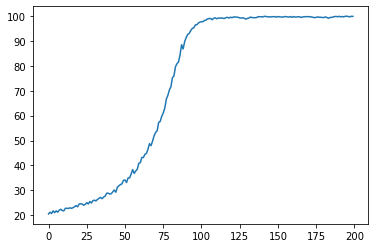

In [2]:
import matplotlib.pyplot as plt
plt.plot(lasted_times);

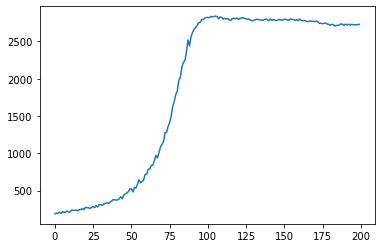

In [3]:
plt.plot(losses);

# For CUDA

In [ ]:
device = "cuda"

In [ ]:
import gym
import torch
from torch import nn, optim
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

class Net(nn.Module):
    def __init__(self, input_size=4, output_size=2):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=-1)
        return x  

device = "cuda"
    
env = gym.make('CartPole-v0')
N = 1000
max_traj_len = 100 # T
net = Net().to(device)
# number of iterations
epoch_size = 300

def loss_fn(net_val, q_val):
    return -(torch.sum(torch.log(net_val) * q_val)) / N

optimizer = optim.Adam(net.parameters(), lr=1e-3)

# to record the progress
lasted_times = [] # a list for mean lasted time for each sample
losses = []

# Learning starts here
for _ in tqdm(range(epoch_size)):
    samples = [] # new samples, because VPG is on policy algo
    
    # a list for lasted time for each sample
    one_epoch_lasted_times = []
    for sample_i in range(N):
        # initial state
        observation = env.reset()
        one_traj = []
        for traj_step in range(max_traj_len):
            action = net(torch.from_numpy(observation).to(device)).cpu().detach().numpy().argmax()
            new_observation, reward, done, info = env.step(action)
            one_traj.append([observation, action, reward])
            observation = new_observation
            if done or traj_step == (max_traj_len - 1):
                samples.append(one_traj)
                one_epoch_lasted_times.append(traj_step + 1)
                break
    
    # appending the mean lasted time for each trajectory
    lasted_times.append(sum(one_epoch_lasted_times) / len(one_epoch_lasted_times))
                
    # Getting the q-values(reward to go)
    q_values = []
    for sample in samples:
        temp = []
        for i in range(len(sample)):
            q = 0
            for t in range(i, len(sample)):
                q += sample[t][2]
            temp.append(q)
        q_values.append(temp)
    
    # appending the q values to the samples list
    for i in range(len(q_values)):
        for j in range(len(q_values[i])):
            samples[i][j].append(q_values[i][j])
    
    # sample shape => [trajectory][state, action, reward, q_value(reward to go)]
    # make torch.tensors for actions, states, q_values
    actions = []
    states = []
    q_values = []
    for sample in samples:
        for state, action, reward, q_value in sample:
            states.append(state)
            actions.append(action)
            q_values.append(q_value)

    actions = torch.from_numpy(np.array(actions)).to(device)
    states = torch.from_numpy(np.array(states)).to(device)
    q_values = torch.from_numpy(np.array(q_values)).to(device)
    net_values = net(states).max(dim=1).values
    
    loss = loss_fn(net_val=net_values, q_val=q_values)
    losses.append(loss.data.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    
    
print(lasted_times)